# Utilites

In [3]:
# import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
import warnings
import tqdm
import pandas as pd
# import librosa
# import librosa.display as display
import biosppy
from scipy import signal
from scipy.stats import zscore
from scipy.io import wavfile
from scipy.fft import fft,fftfreq
from scipy.fftpack import fft

warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
mlp.rc("xtick",labelsize=10)
mlp.rc("ytick",labelsize=10)
mlp.rc("axes",labelsize=11)
plt.rcParams["figure.figsize"] = [11,5]
plt.rcParams["figure.dpi"] = 300

CURR_DIR = os.getcwd()

In [4]:
#  make necessary definitions

# directories definitions
MAIN_DIR = "."
if os.path.basename(os.getcwd())!="Silent-Interface-for-IOT-Devices":
    os.chdir("..")

DATA_DIR = os.path.join(MAIN_DIR,"new dataset")
FIG_DIR = os.path.join(MAIN_DIR,"figures")
PICKLE_DIR = os.path.join(MAIN_DIR,"pickles")
os.makedirs(FIG_DIR,exist_ok=True)
os.makedirs(PICKLE_DIR,exist_ok=True)

# hardware definitions
"""
https://docs.openbci.com/docs/02Cyton/CytonDataFormat#:~:text=By%20default%2C%20our%20Arduino%20sketch,of%200.02235%20microVolts%20per%20count
"""
SAMPLING_RATE = 250 #Hz
NUM_CHANNELS = 8 
ADC_RESOLUTION = 24 #bits
ADC_GAIN = 24.0
REF_VOLTAGE = 4.5 #Volts
SCALE_FACTOR = (REF_VOLTAGE/float((pow(2,23))-1)/ADC_GAIN)*1000000.0 #micro-volts

# dataset definitions
# MODE = SILENT
SPEAKER = ["RL","RN","SR","US"]
SESSION = ["Session"+ str(i) for i in range(1,9)]
SENTENCES =["अबको समय सुनाउ","एउटा सङ्गित बजाउ","आजको मौसम बताउ","बत्तिको अवस्था बदल","पङ्खाको स्तिथी बदल"]
SENTENCE_LABEL= np.array(SENTENCES)[[3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0]]

# a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIG_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
# print(DATA_DIR)

In [5]:
all_files = glob.glob(DATA_DIR+"/*/**/*.txt",recursive=True)
print(len(all_files))     #no. of .txt files in new_dataset

165


In [6]:
def parser(files,FILTER=True,):
    """
    parser function to extract utterances from .txt file and store them in a dictionary
    """
    
    dataset = {"data":[], "speaker":[], "labels":[], "session":[], "filename":[]}
    def get_data(file):
        session = file.split("/")[-2]
        speaker = file.split("/")[-3]
        filename = file.split("/")[-1]
        signal = read_data(file)
#         print(signal)
        
        # only take files with 15 labels         
        if (len(signal)!=len(SENTENCE_LABEL) and FILTER):
            return
        
        dataset["data"].extend(signal)
        dataset["speaker"].extend([speaker]*len(signal))
        dataset["session"].extend([session]*len(signal))
        dataset["labels"].extend(SENTENCE_LABEL)
        dataset["filename"].extend([filename]*len(signal))

    def read_data(file):
        f = open(file, 'r')
        contents = map(lambda x: x.strip(), f.readlines())
        #the file starts with '%' and some instruction before data and removing these data 
        frames_original = list(filter(lambda x : x and x[0] != '%', contents))[1:]
        #the data row contains channe*len(signal)*len(signal)ls info digital trigger and accelerometer info separated by comma
        frames_original = list(map(lambda s : list(map(lambda ss: ss.strip(), s.split(','))), frames_original))
        # (8 channels) + digital triggers
        # the digital trigger is in a[16], used to indicate the utterance
        frames = list(map(lambda a: list(map(float, a[1:9])) + [float(a[16])] , frames_original))
        frames = np.array(frames)
        indices = []
        signal = []
        for index,f in enumerate(frames[:,-1]):
            if(bool(f) ^ bool(frames[(index+1) if ((index+1)<len(frames)) else index,-1]) ):
                indices.append(index)
                if len(indices)>1 and len(indices)%2==0:
                    signal.append(frames[indices[len(indices)-2]:indices[len(indices)-1],:-1])   
        
        # convert to microVolts and return
        return np.array(signal)*SCALE_FACTOR
        
    for file,i in zip(files,tqdm.tqdm(range(1,len(files)+1),desc="PARSING DATA")):
        get_data(file)

    
    return dataset

In [7]:
Picklefile = "Raw_data_dict.pickle"
if Picklefile in os.listdir(PICKLE_DIR):
    all_data = pickle.load(open(os.path.join(PICKLE_DIR,Picklefile),"rb"))
    print("Read Task Accomplished")
else:
    all_data = parser(all_files)
    pickle.dump(all_data,open(os.path.join(PICKLE_DIR, Picklefile),"wb"))
    print("Write Task Accomplished")

Read Task Accomplished


In [12]:
print(type(all_data))
print(all_data.keys())
# print(all_data)
# print([len(all_data[i]) for i in all_data.keys()])
print([len(x[-1]) for x in all_data.items()])


<class 'dict'>
dict_keys(['data', 'speaker', 'labels', 'session', 'filename'])
[2310, 2310, 2310, 2310, 2310]


In [14]:
np.array(all_data['data']).shape

(2310,)

In [85]:
df = pd.DataFrame(all_data)
# print(df.shape)
df.to_pickle(PICKLE_DIR + '/new_data_dict_dataframe.pickle') #to store data as dataframe and easy read.

(2310, 5)


In [17]:
# to import data directly in form of dataframe, but initialize the first and second cell for variables and library.
if "data_dict_dataframe.pickle" in os.listdir(PICKLE_DIR):
    df = pd.read_pickle(PICKLE_DIR + '/new_data_dict_dataframe.pickle')

In [18]:
df.head(5)

,data,speaker,labels,session,filename
0,"[[-578.4069178962014, 115.98874625895128, -753...",US,बत्तिको अवस्था बदल,session3,OpenBCI-RAW-2021-05-31_11-54-00.txt
1,"[[-580.1115876569256, 116.29749064317794, -746...",US,आजको मौसम बताउ,session3,OpenBCI-RAW-2021-05-31_11-54-00.txt
2,"[[-580.9693795061489, 110.45616563725211, -744...",US,एउटा सङ्गित बजाउ,session3,OpenBCI-RAW-2021-05-31_11-54-00.txt
3,"[[-583.4978769419047, 114.20817006136829, -760...",US,पङ्खाको स्तिथी बदल,session3,OpenBCI-RAW-2021-05-31_11-54-00.txt
4,"[[-586.8392008034677, 109.91809759360412, -755...",US,अबको समय सुनाउ,session3,OpenBCI-RAW-2021-05-31_11-54-00.txt


In [22]:
df.tail(5)

,data,speaker,labels,session,filename
2305,"[[-269.37257217214375, -397.4746542533448, 98....",RL,बत्तिको अवस्था बदल,session2,OpenBCI-RAW-2021-06-07_14-39-10.txt
2306,"[[-271.0637304779678, -397.59601724081693, 105...",RL,आजको मौसम बताउ,session2,OpenBCI-RAW-2021-06-07_14-39-10.txt
2307,"[[-276.6697400726627, -394.3726075624058, 108....",RL,एउटा सङ्गित बजाउ,session2,OpenBCI-RAW-2021-06-07_14-39-10.txt
2308,"[[-275.7774601802369, -398.93445890733113, 104...",RL,पङ्खाको स्तिथी बदल,session2,OpenBCI-RAW-2021-06-07_14-39-10.txt
2309,"[[-287.3372192533352, -402.77088263972945, 109...",RL,अबको समय सुनाउ,session2,OpenBCI-RAW-2021-06-07_14-39-10.txt


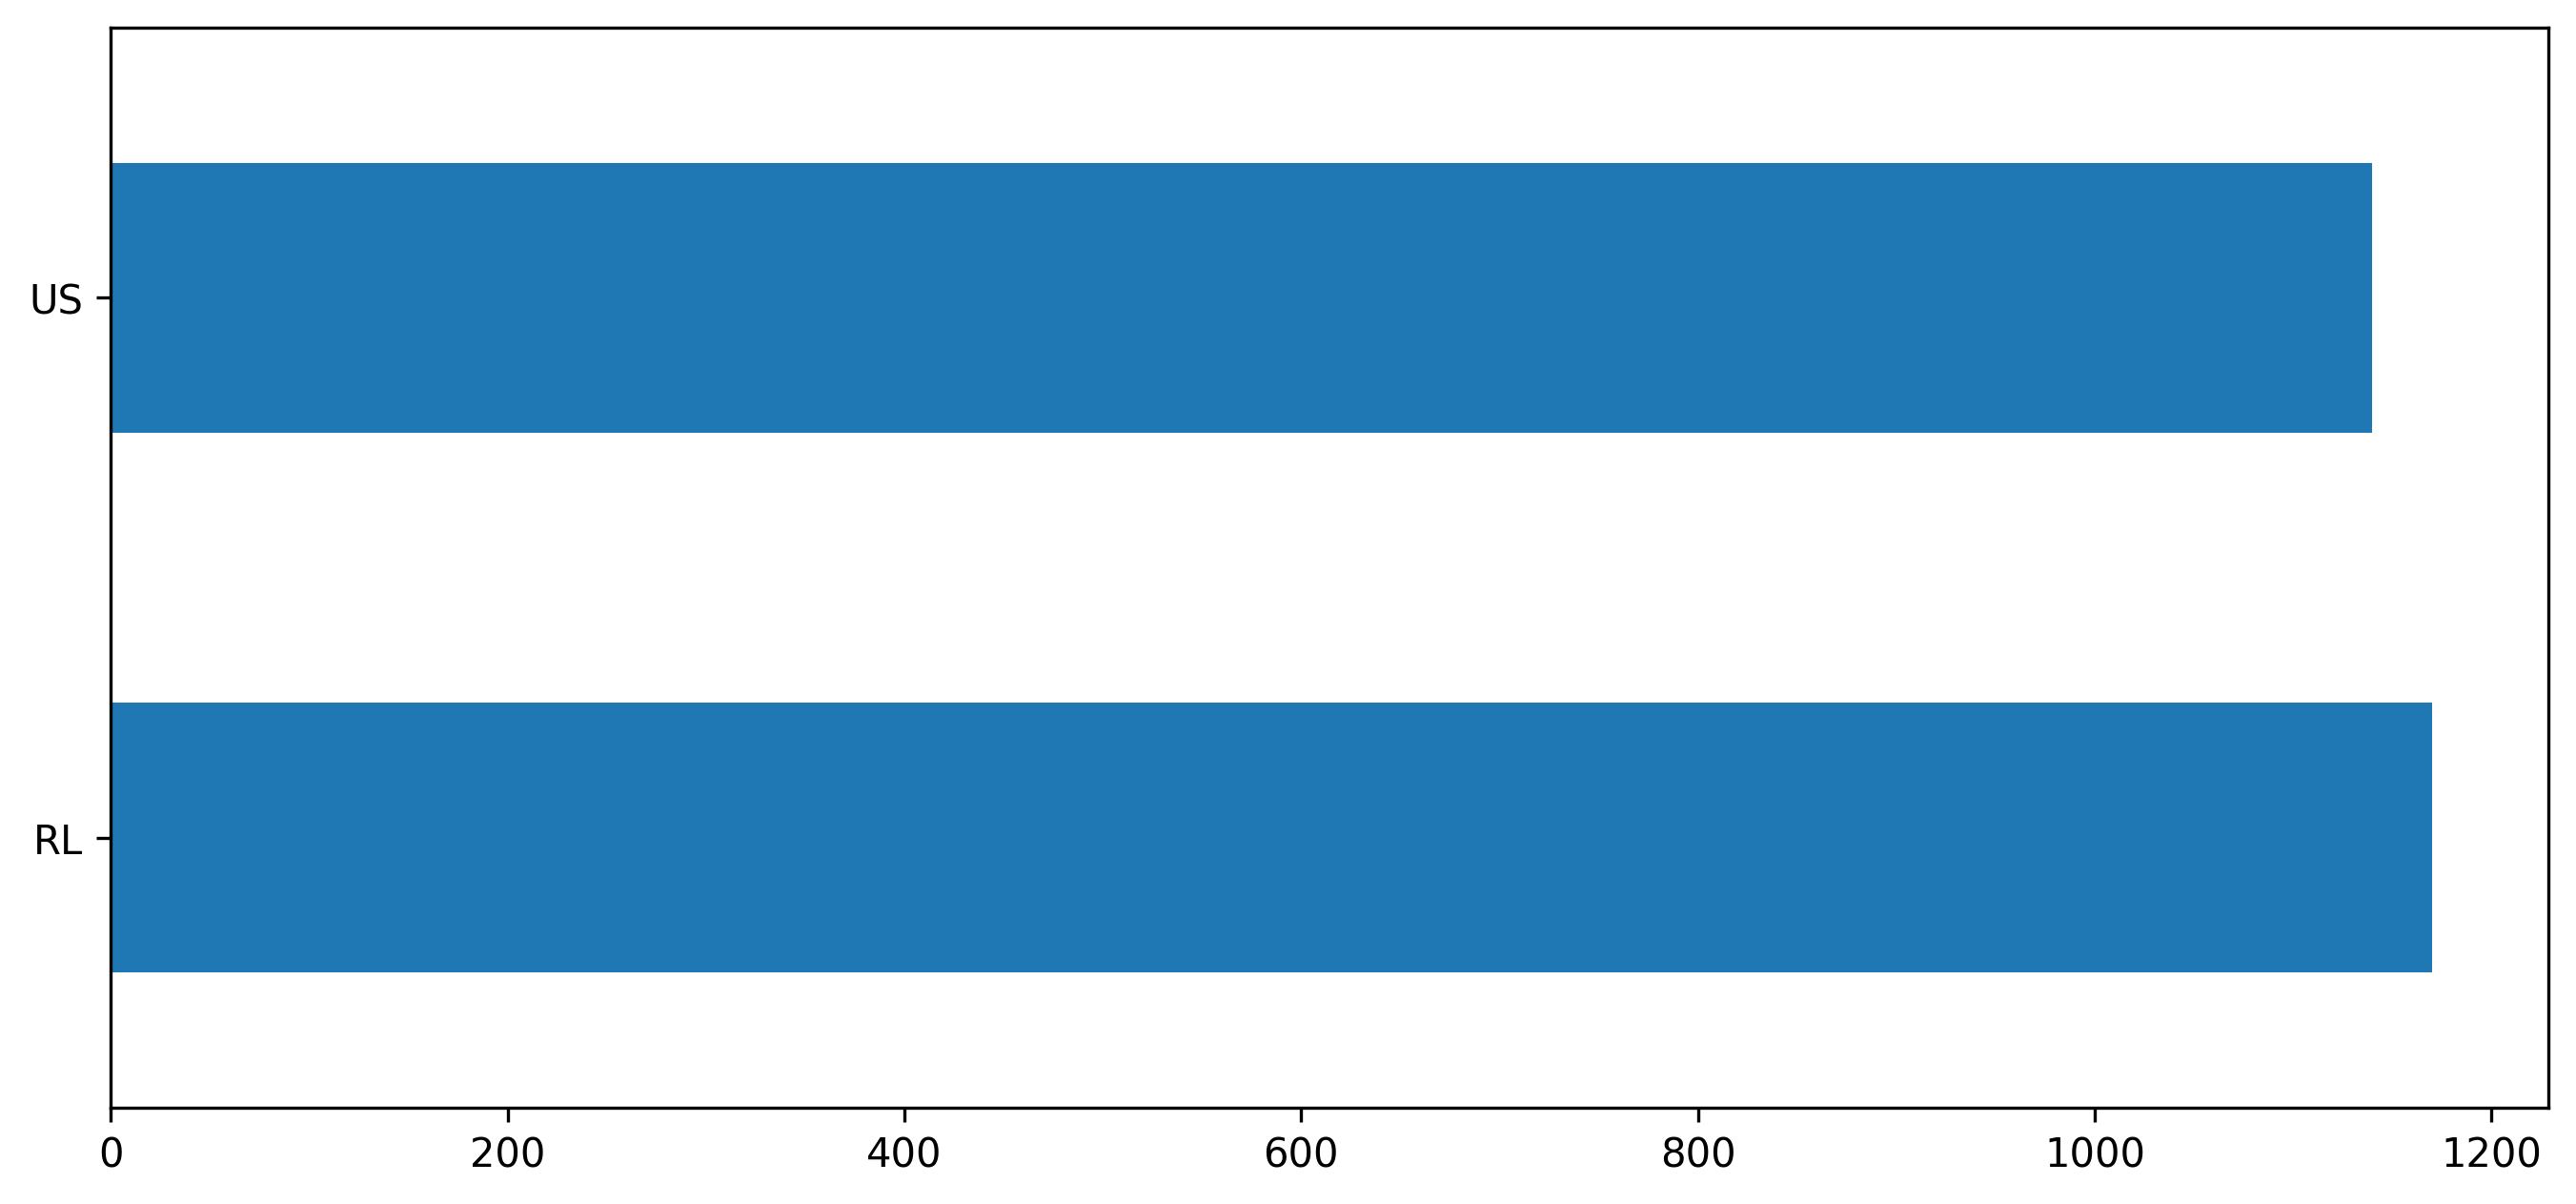

In [23]:
df["speaker"].value_counts().plot.barh()
plt.show()

## Analyze sample length

In [84]:
all_sentences = df
all_sent_length = [x.shape[0]/SAMPLING_RATE for x in all_sentences["data"]]

(2310, 5)


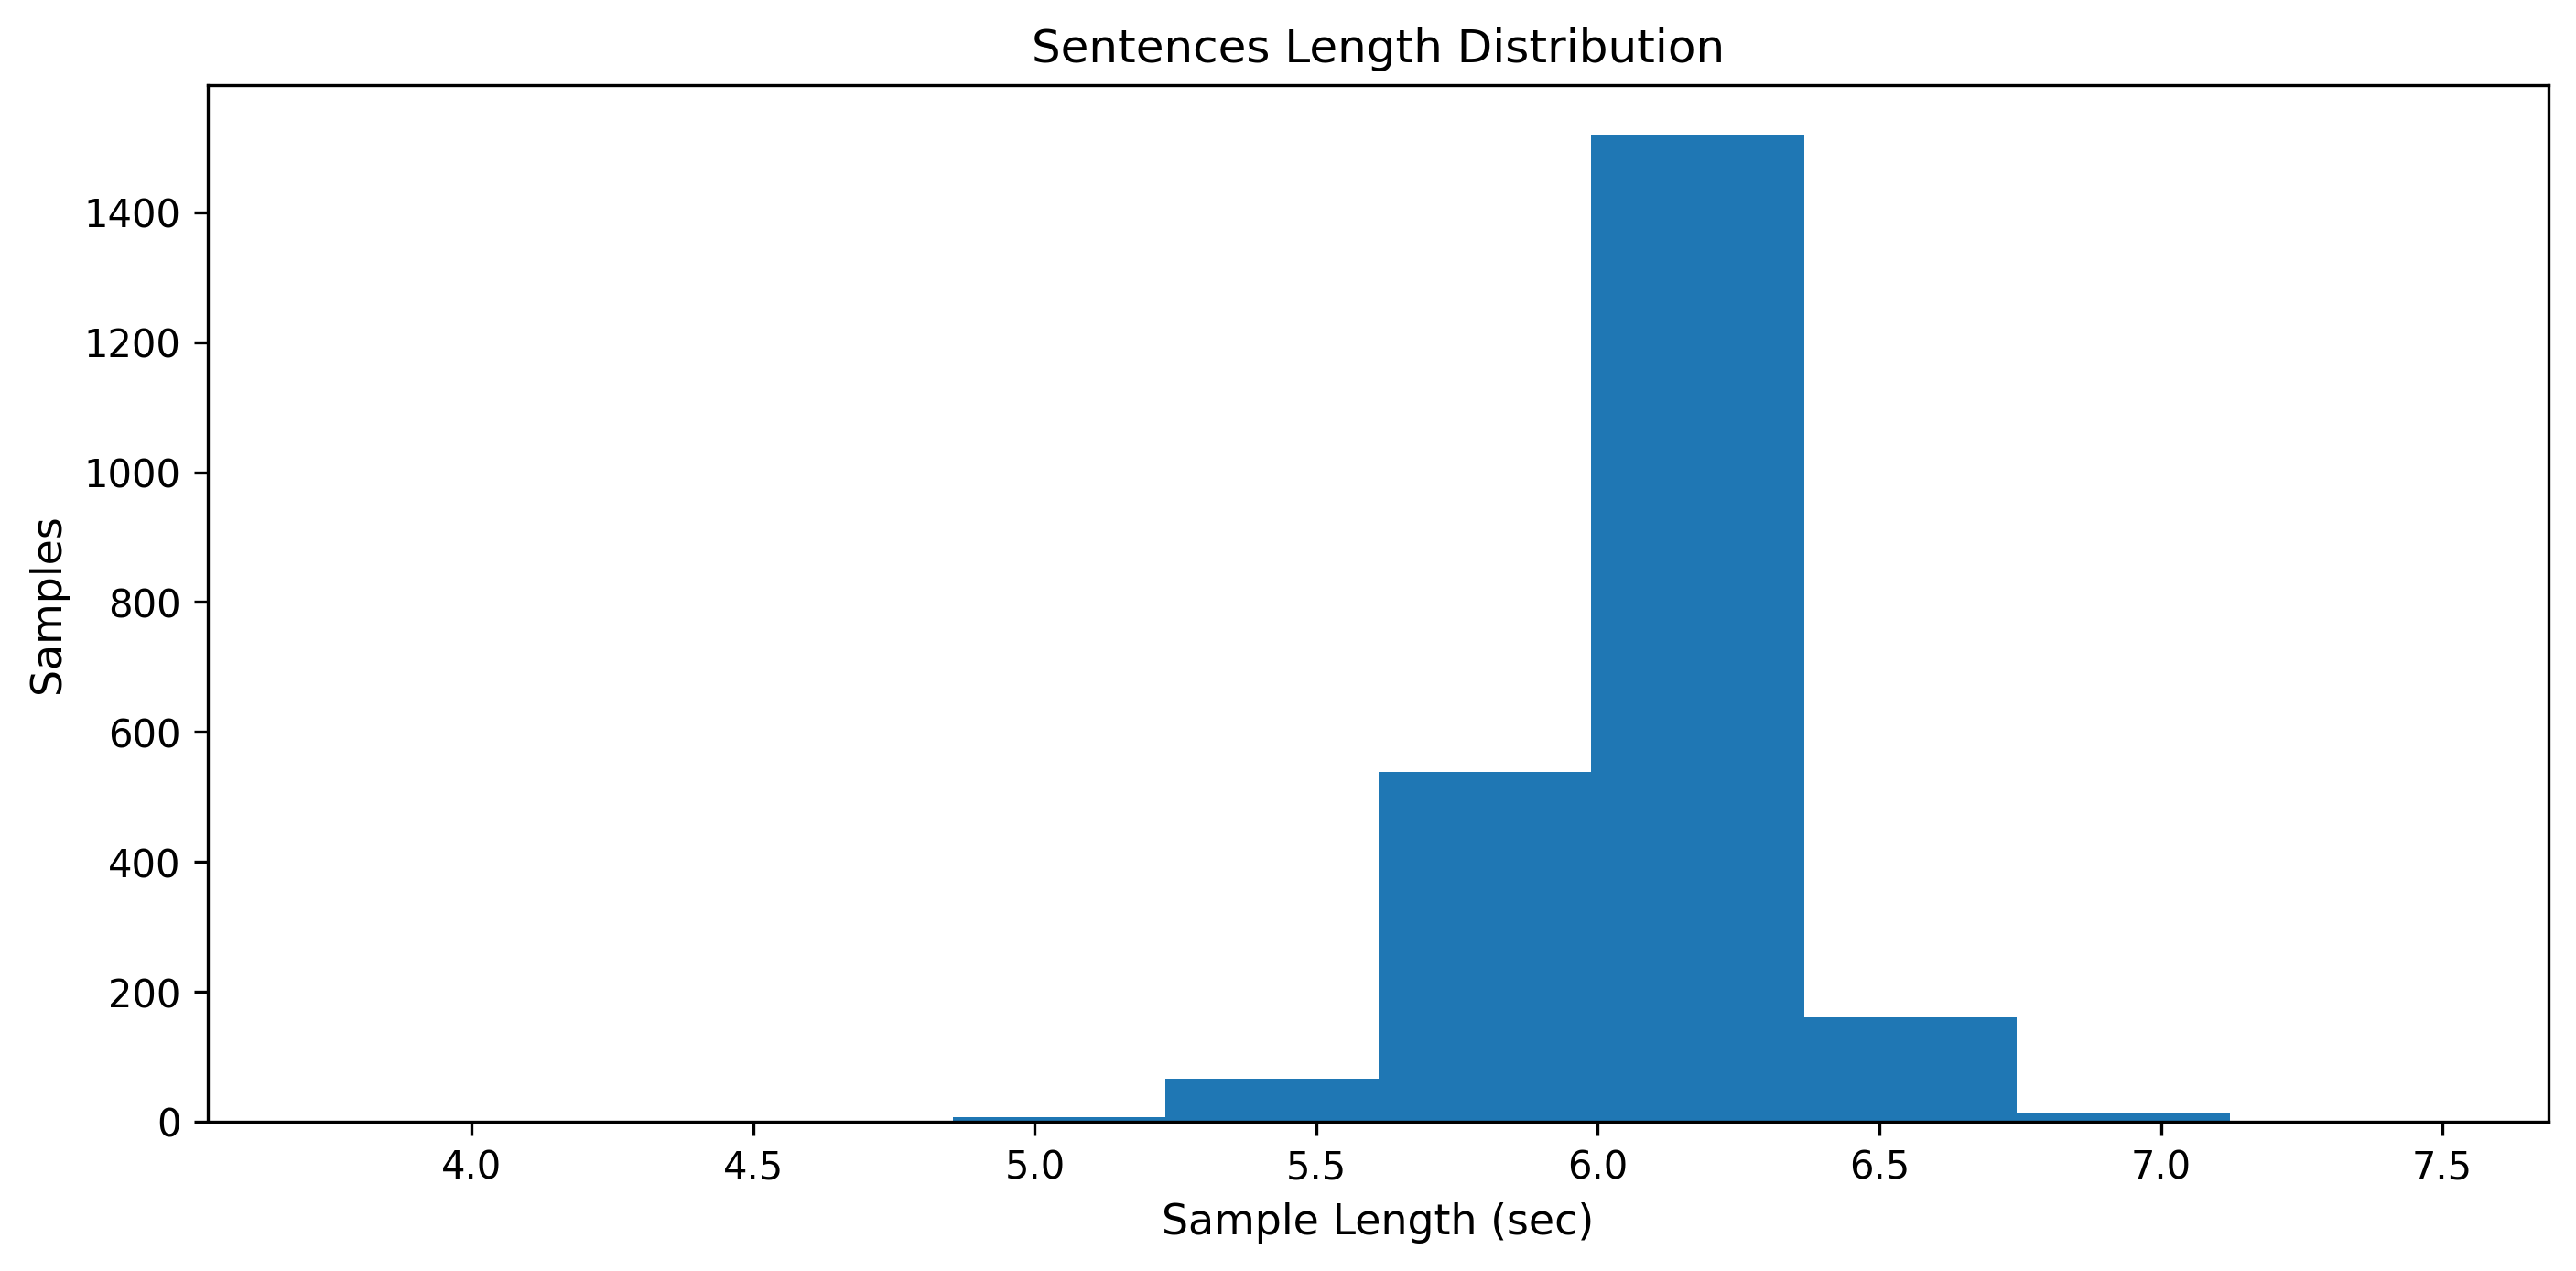

Max length of sentence utterances in seconds: 7.50s
Min length of sentence utterances in seconds: 3.72s
Avg length of sentence utterances in seconds: 6.09s


In [29]:
plt.hist(all_sent_length)
plt.xlabel("Sample Length (sec)")
plt.ylabel("Samples")
plt.title("Sentences Length Distribution")
# save_fig("length distribution")
plt.show()
print("Max length of sentence utterances in seconds: %.2fs" % np.max(all_sent_length))
print("Min length of sentence utterances in seconds: %.2fs" % np.min(all_sent_length))
print("Avg length of sentence utterances in seconds: %.2fs" % np.mean(all_sent_length))

In [86]:
all_sent_RL = df.query('speaker=="RL"')
all_sent_US = df.query('speaker=="US"')

all_sent_length_RL = [x.shape[0]/SAMPLING_RATE for x in all_sent_RL["data"]]
all_sent_length_US = [x.shape[0]/SAMPLING_RATE for x in all_sent_US["data"]]

(1170, 5)


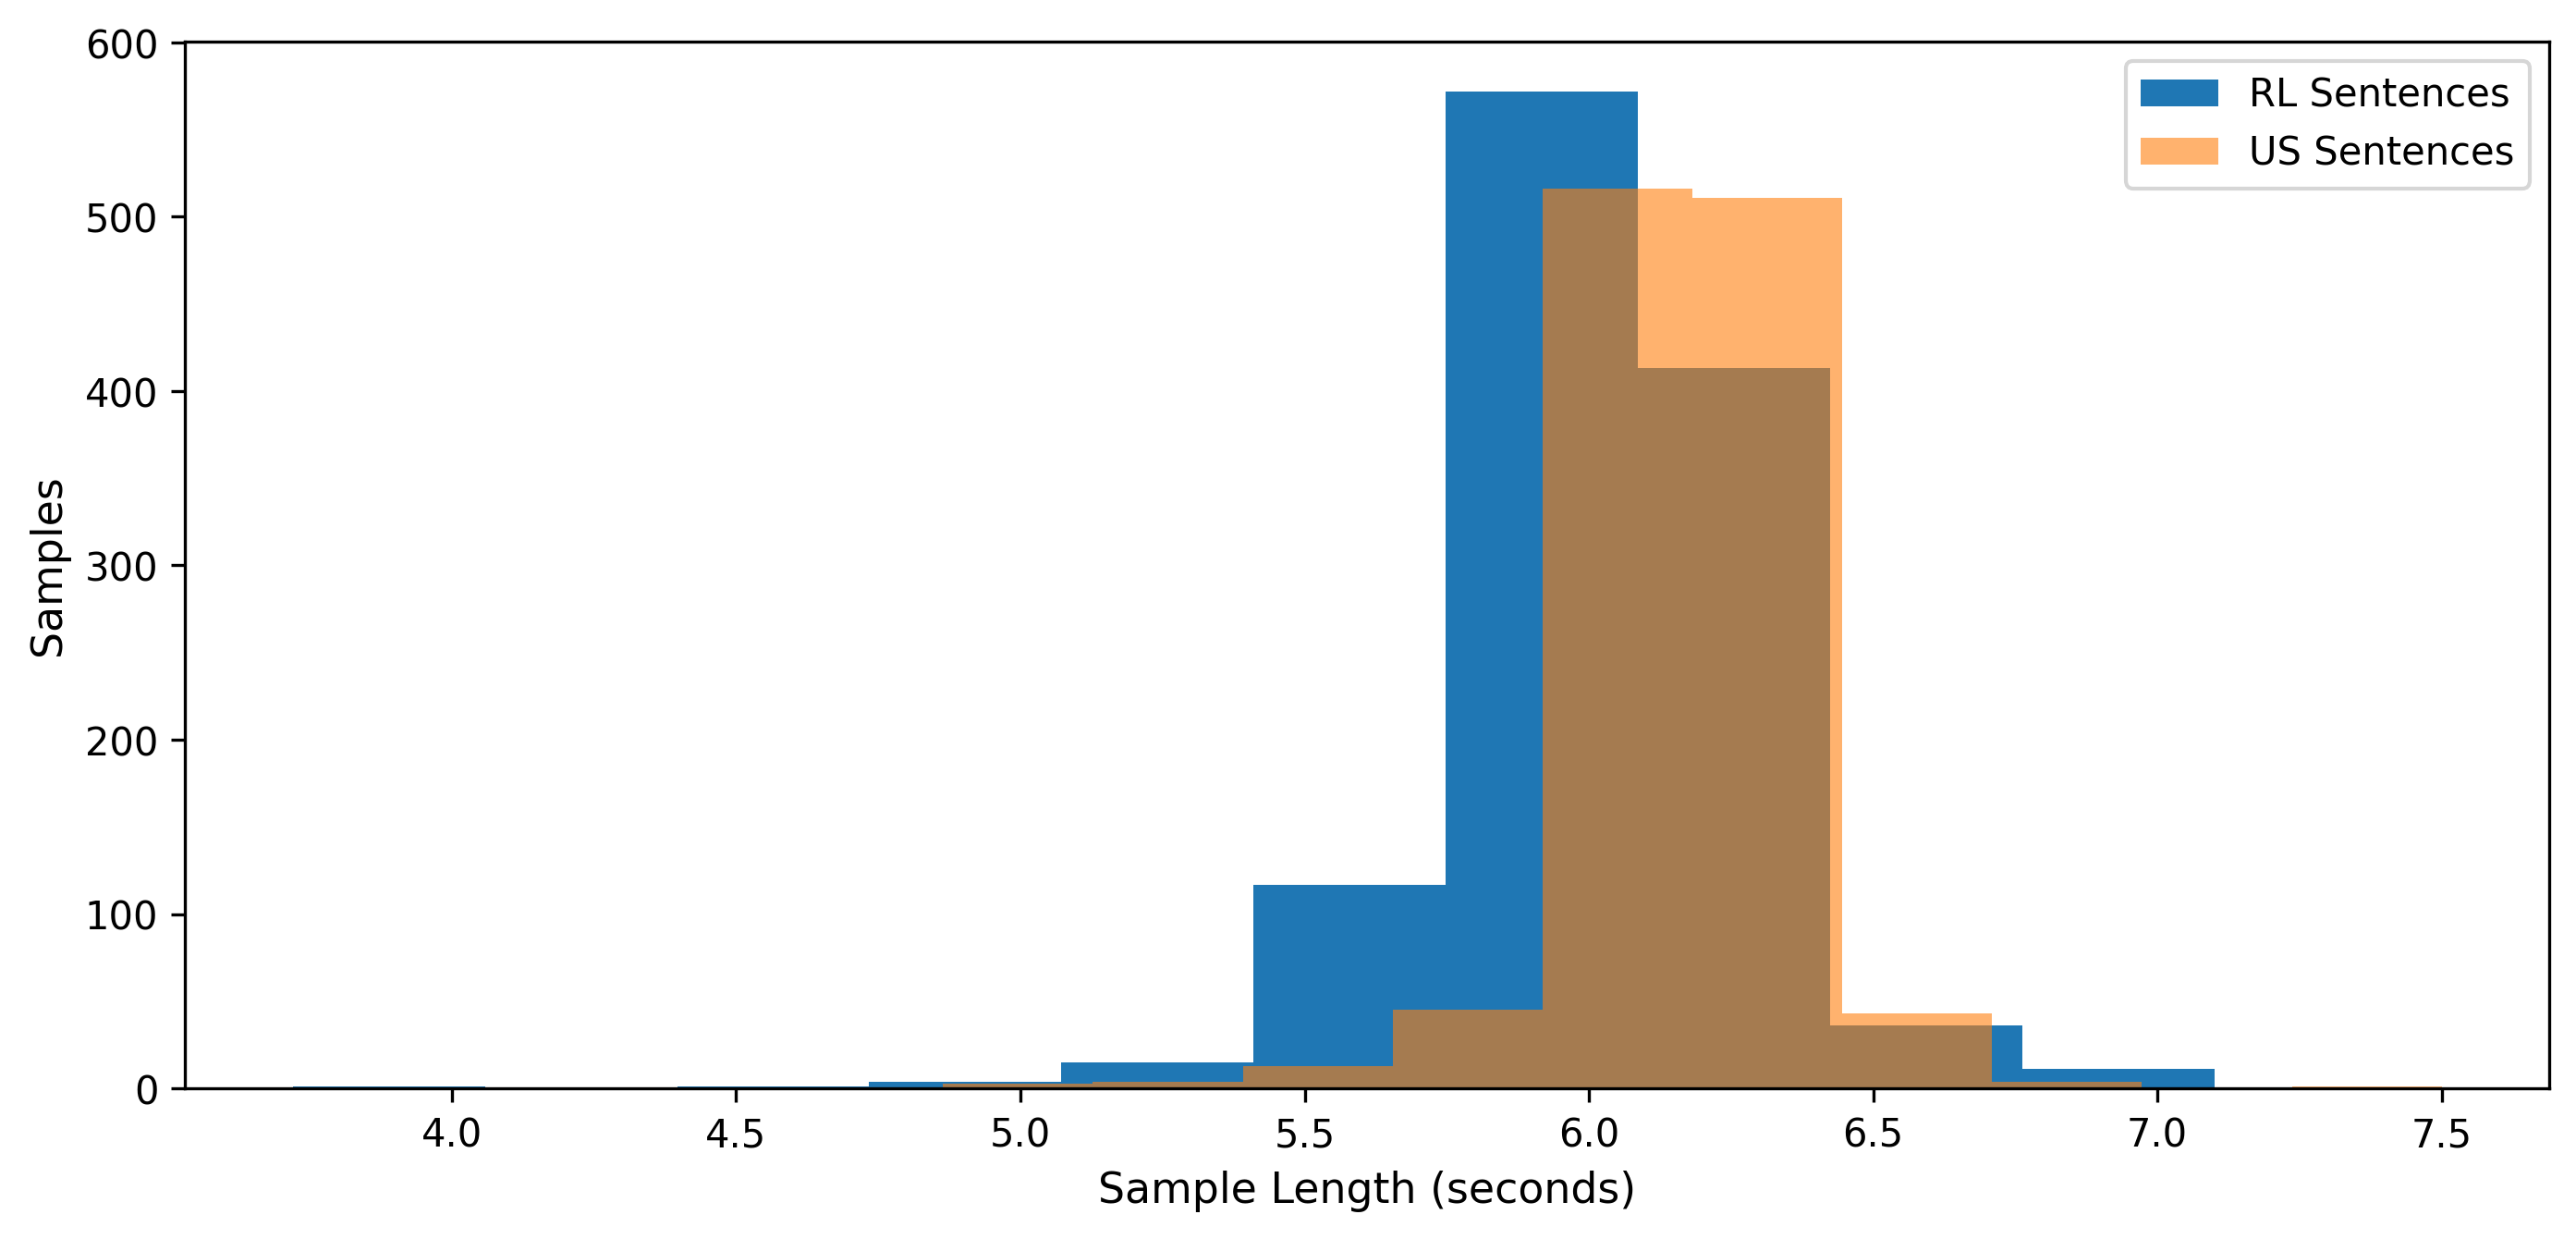

In [32]:
plt.hist(all_sent_length_RL)
plt.hist(all_sent_length_US,alpha=0.6)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
# save_fig("length distribution")
plt.legend(["RL Sentences","US Sentences"])
plt.show()

In [81]:
all_sent_RL = df.query('speaker=="RL" and labels=="आजको मौसम बताउ"')
all_sent_US = df.query('speaker=="US" and labels=="आजको मौसम बताउ"')
# print(all_sent_RL.shape)

all_sent_length_RL = [x.shape[0]/SAMPLING_RATE for x in all_sent_RL["data"]]
all_sent_length_US = [x.shape[0]/SAMPLING_RATE for x in all_sent_US["data"]]

(234, 5)


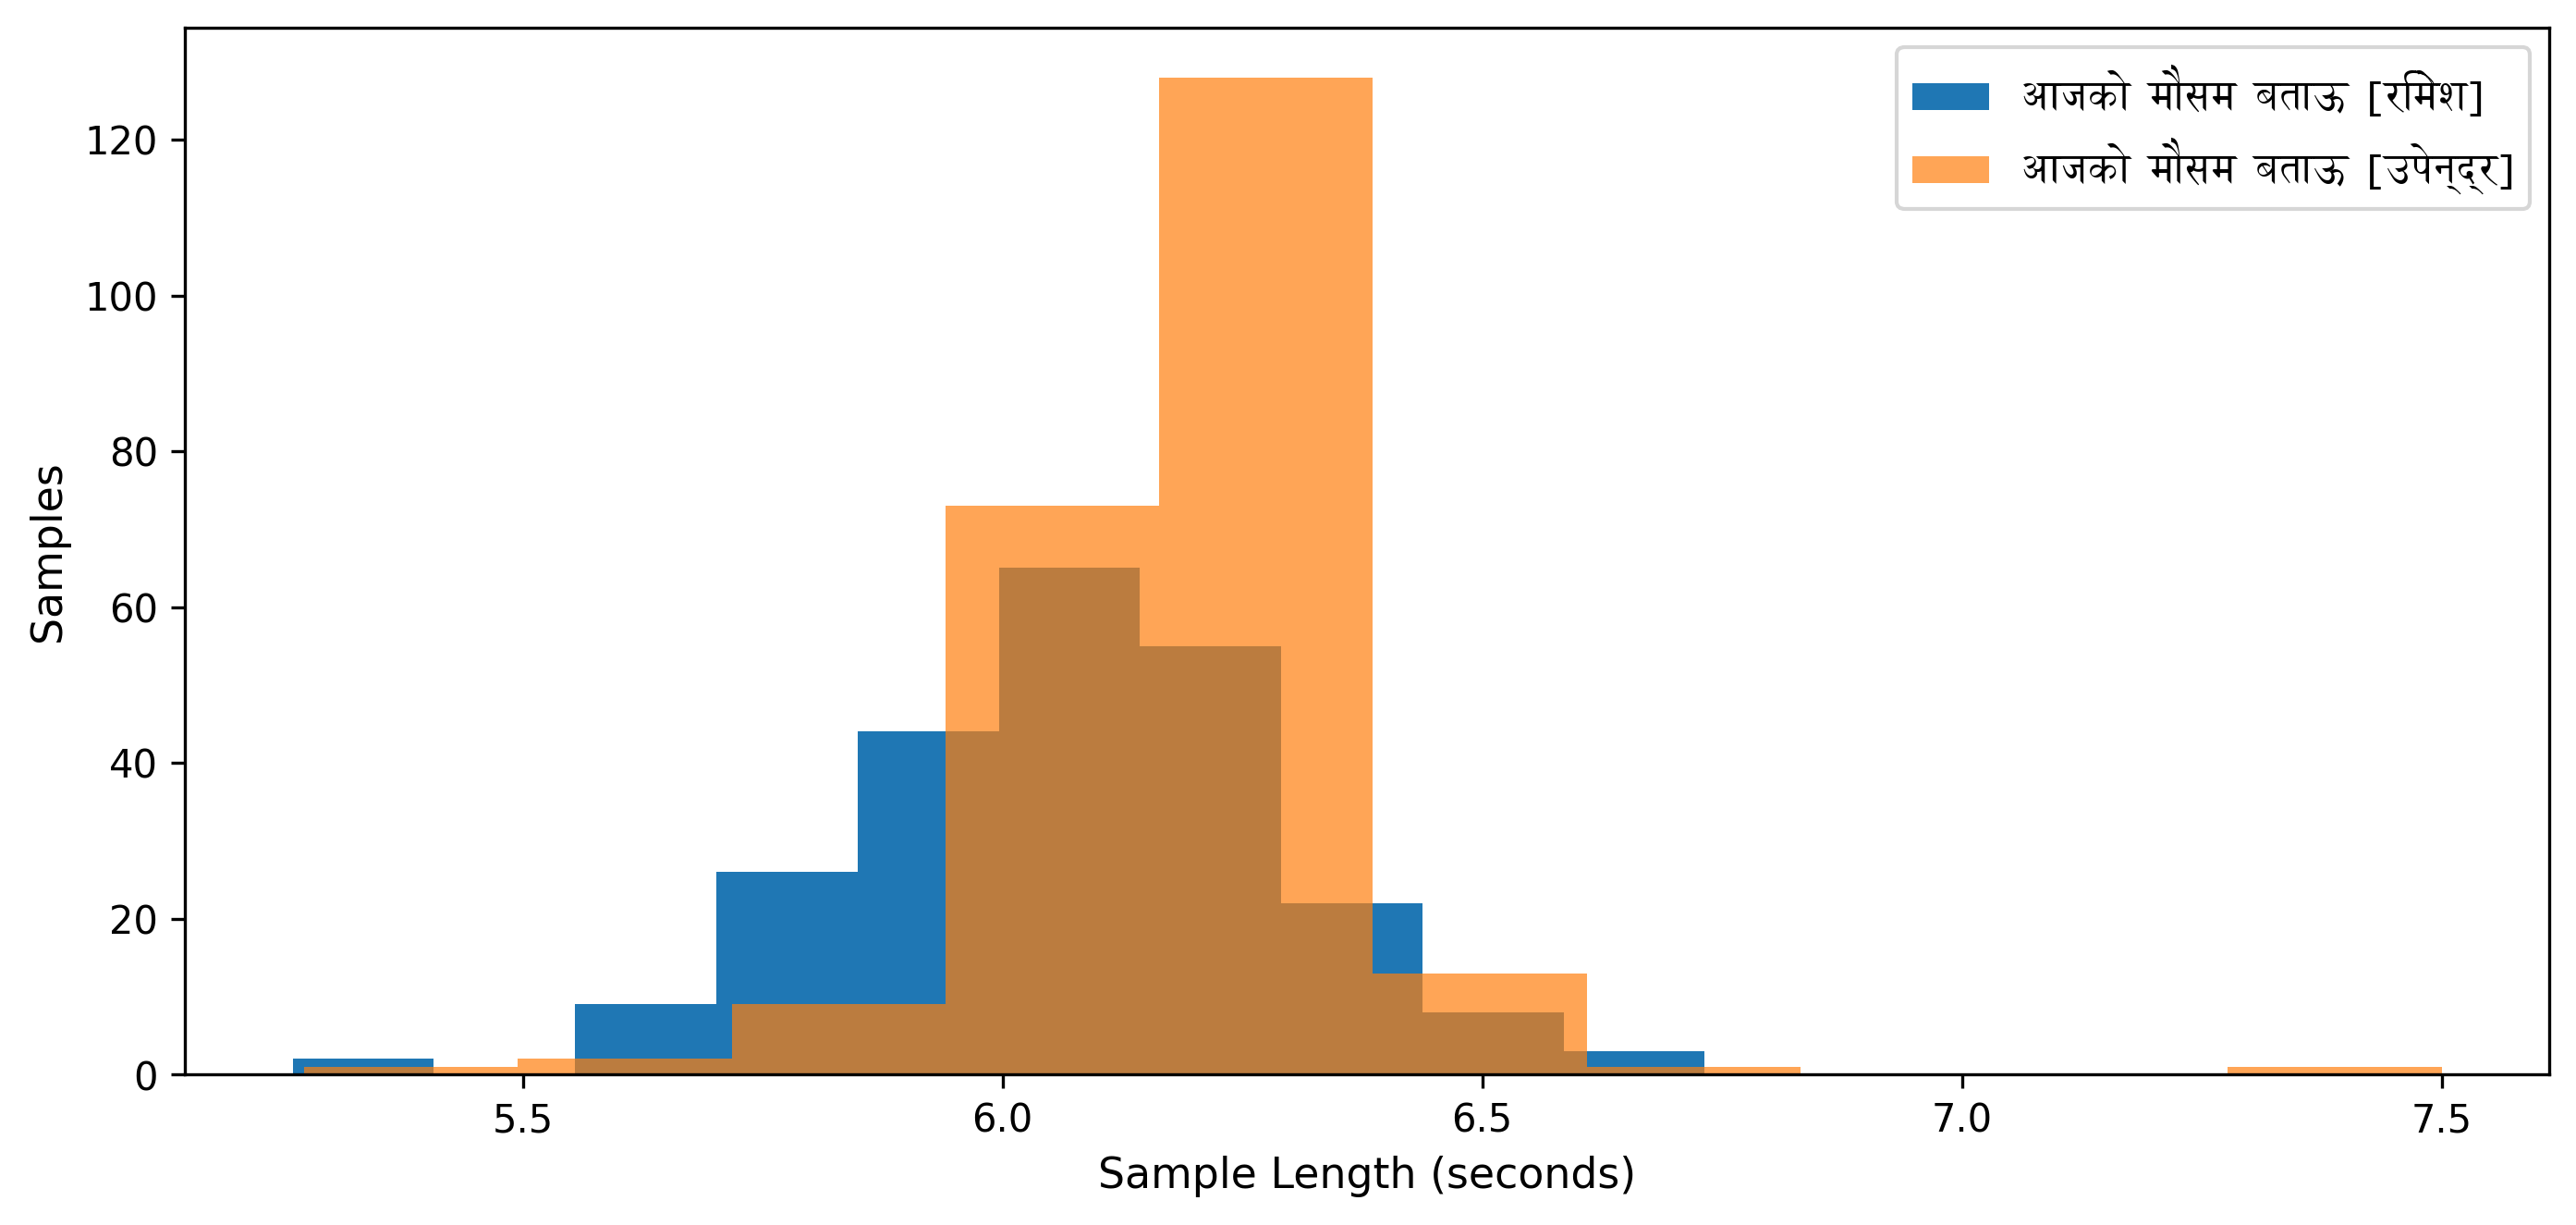

In [34]:
from matplotlib.font_manager import FontProperties
font_path = '/home/graviton/file/software/python/Kalimati.otf'    # just testing nepali font
fp = FontProperties(fname = font_path)

plt.hist(all_sent_length_RL)
plt.hist(all_sent_length_US,alpha=0.7)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
# save_fig("length distribution")
plt.legend(["आजको मौसम बताऊ [रिमेश]","आजको मौसम बताऊ [उपेन्द्र]"], prop = fp)
plt.show()

## Raw Signal

In [89]:
x = 2
sample_RL = df.query('speaker=="RL" and labels=="आजको मौसम बताउ"')["data"].iloc[x]
sample_US = df.query('speaker=="US" and labels=="आजको मौसम बताउ"')["data"].iloc[x]

def sample_sentence(index, speaker, label = "आजको मौसम बताउ"):
    return df.query('speaker=="'+speaker+'" and labels=="'+ label+'"')["data"].iloc[index]

print("Length of RL samples in seconds: %.2f s" % (len(sample_RL)/SAMPLING_RATE))
print("Length of US samples in seconds: %.2f s" % (len(sample_US)/SAMPLING_RATE))
print(sample_RL.shape)

Length of RL samples in seconds: 6.22 s
Length of US samples in seconds: 6.55 s
(1554, 8)


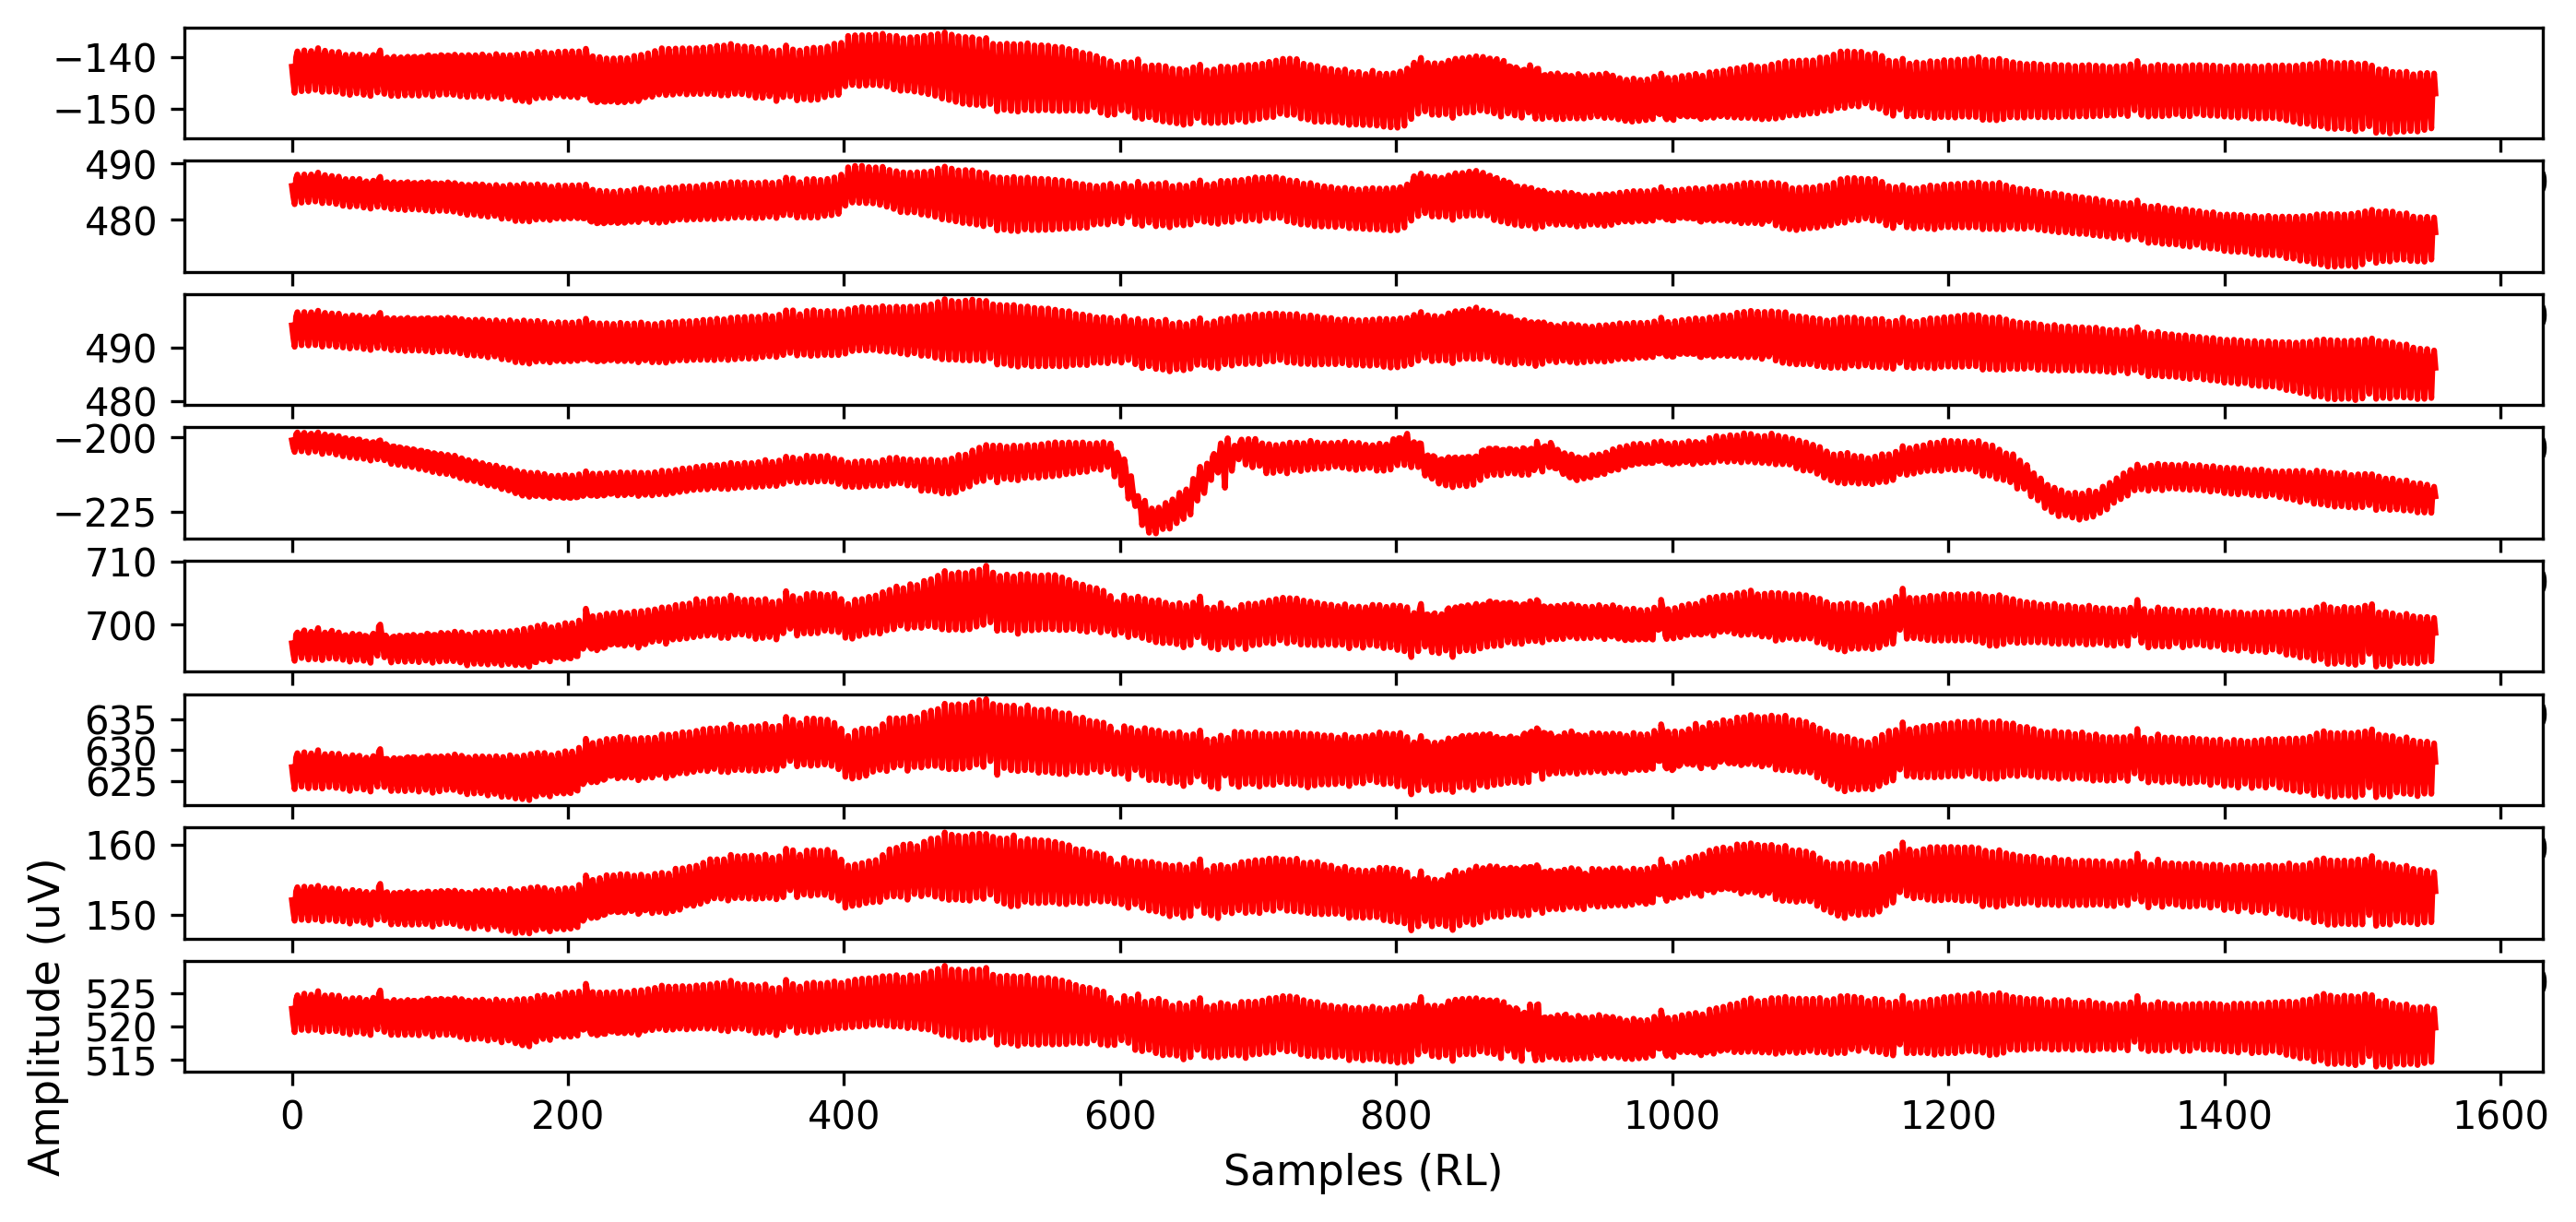

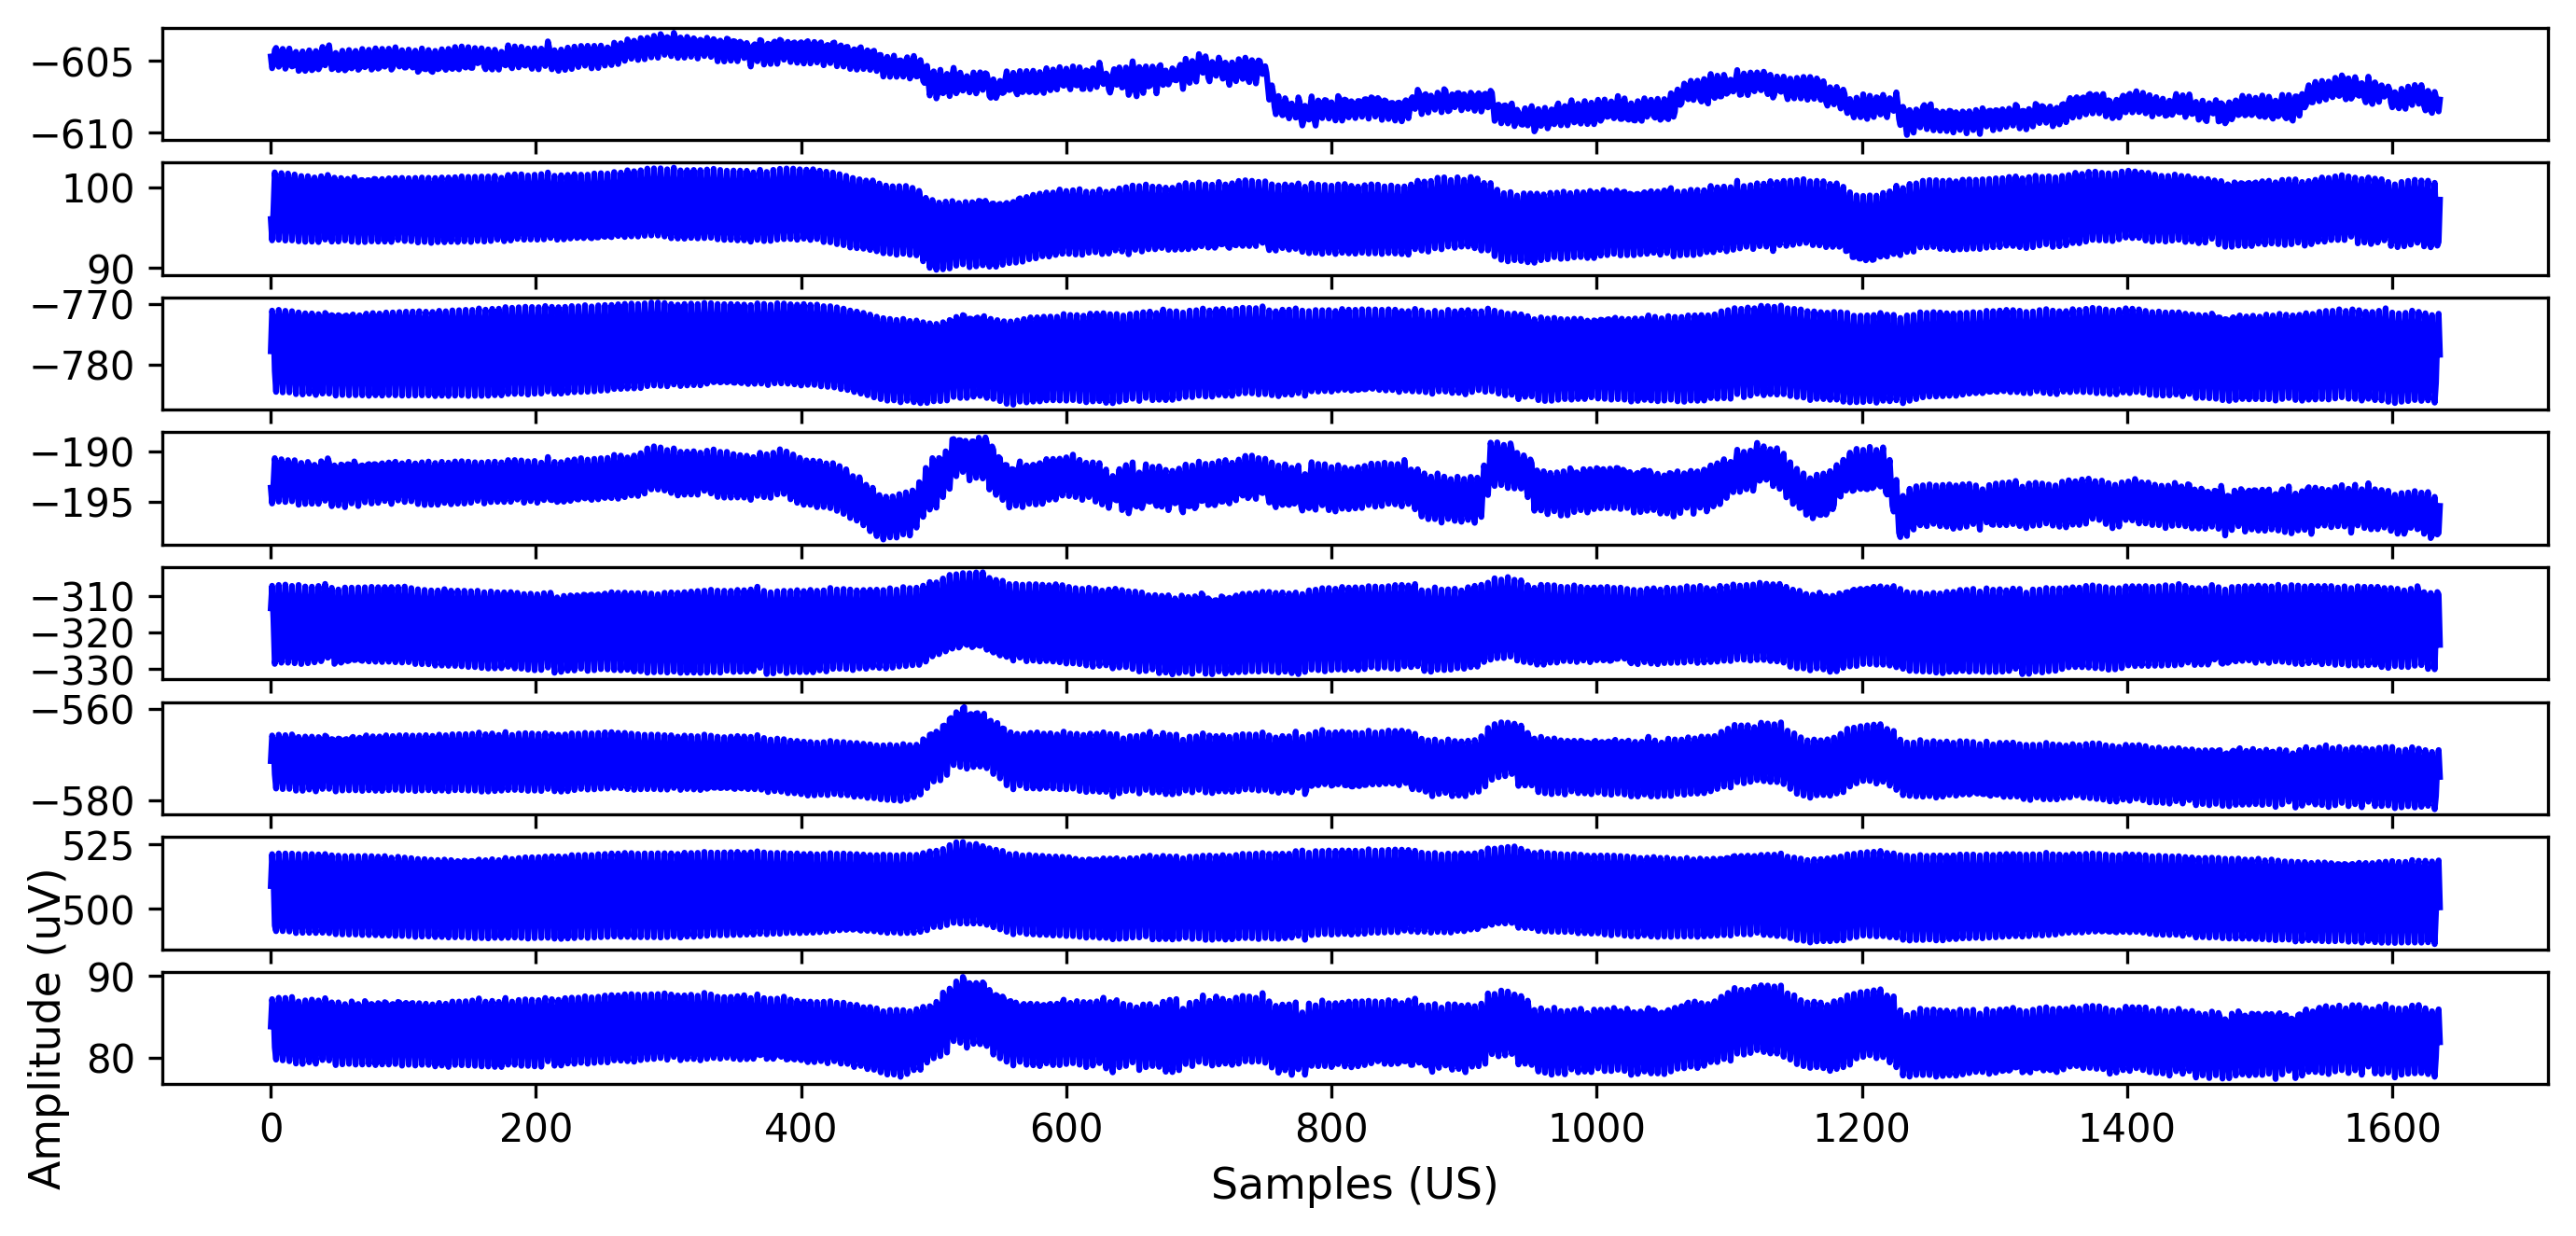

In [38]:
fig, axes = plt.subplots(nrows=8,ncols=1)
for i in range(8):
    axes[i].plot(sample_RL[:,i],"r")

plt.xlabel("Samples (RL)")
plt.ylabel("Amplitude (uV)")
plt.show()

fig, axes = plt.subplots(nrows=8,ncols=1)
for i in range(8):
    axes[i].plot(sample_US[:,i],"b")

plt.xlabel("Samples (US)")
plt.ylabel("Amplitude (uV)")
plt.show()

In [48]:
print([np.round(max(sample_RL[:,i]) - min(sample_RL[:,i]),2) for i in range(NUM_CHANNELS)])
print([np.round(max(sample_US[:,i]) - min(sample_US[:,i]),2) for i in range(NUM_CHANNELS)])

[19.61, 17.96, 18.75, 33.97, 15.99, 16.45, 14.51, 15.17]
[7.13, 12.67, 16.93, 10.15, 27.94, 22.27, 39.71, 12.5]


## FFT

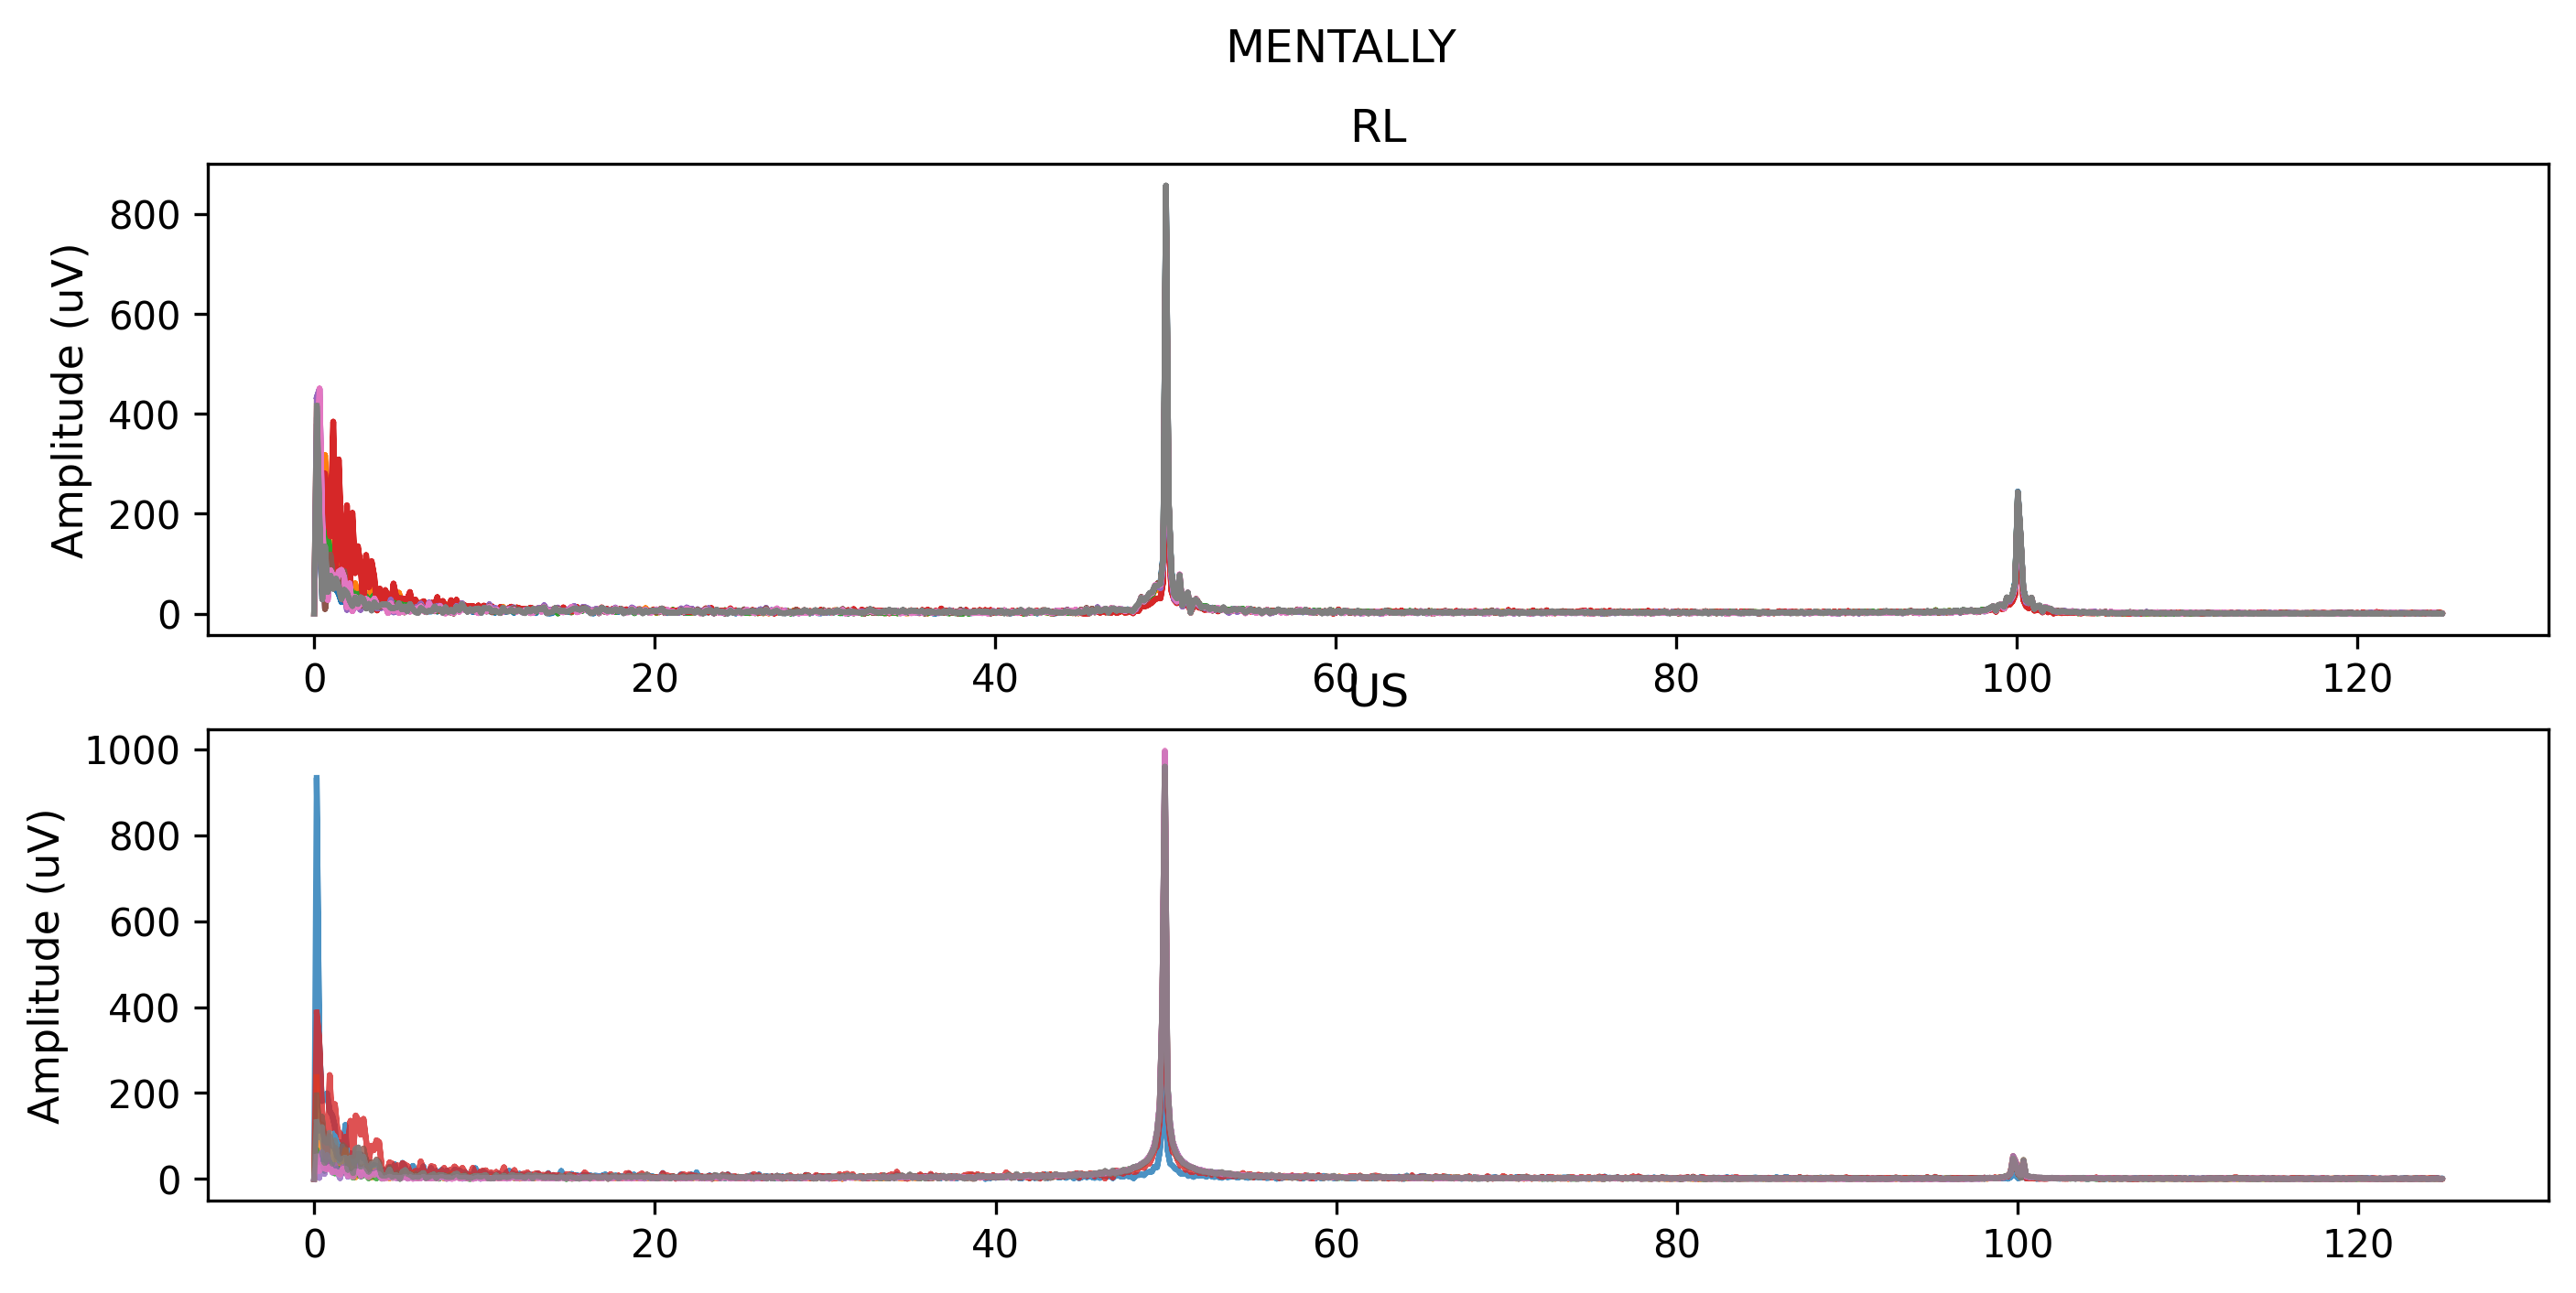

In [42]:
def FFT(data1, data2, MODE):
    plt.suptitle(MODE)
    plt.subplot(211).set_title("RL")
    N = len(data1)
    for i in range(NUM_CHANNELS):
        y = fft(zscore(data1[:,i]))
        x = fftfreq(N,1/SAMPLING_RATE)
        plt.plot(abs(x),abs(y))
    plt.ylabel("Amplitude (uV)")

    plt.subplot(212).set_title("US")
    N = len(data2)
    for i in range(NUM_CHANNELS):
        y = fft(zscore(data2[:,i]))
        x = fftfreq(N,1/SAMPLING_RATE)
        plt.plot(abs(x),abs(y),alpha=0.8)

    plt.ylabel("Amplitude (uV)")
    plt.title("US")
    plt.show()

FFT(data1=sample_RL, data2=sample_US, MODE="MENTALLY")

In [52]:
print(len(sample_RL[:,x])); print(len(sample_US[:,x]))

1554
1637


## STFT

In [ ]:
def STFT(data1,data2,MODE,channel=4):
    plt.suptitle(MODE)
    plt.subplot(121).set_title("RL")
    win = signal.windows.hann(50)
    f, t, Zxx = signal.stft(data1[:,channel], fs=SAMPLING_RATE, window = win, nperseg=len(win))
    plt.pcolormesh(t, f, 20*np.log10(abs(Zxx)), shading='gouraud',cmap="magma")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
#     plt.ylim([0,20])
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(122).set_title("US")
    f, t, Zxx = signal.stft(data2[:,channel], fs=SAMPLING_RATE, nperseg=50)
    plt.pcolormesh(t, f, 20*np.log10(abs(Zxx)), shading='gouraud',cmap="magma")
    plt.xlabel('Time [sec]')
#     plt.ylim([0,20])
    plt.colorbar(format='%+2.0f dB')
    plt.show()

STFT(data1=sample_sentence(2, "RL", SENTENCES[0]),data2=sample_sentence(2, "US", SENTENCES[0]), MODE="MENTALLY")

## SPECTROGRAM

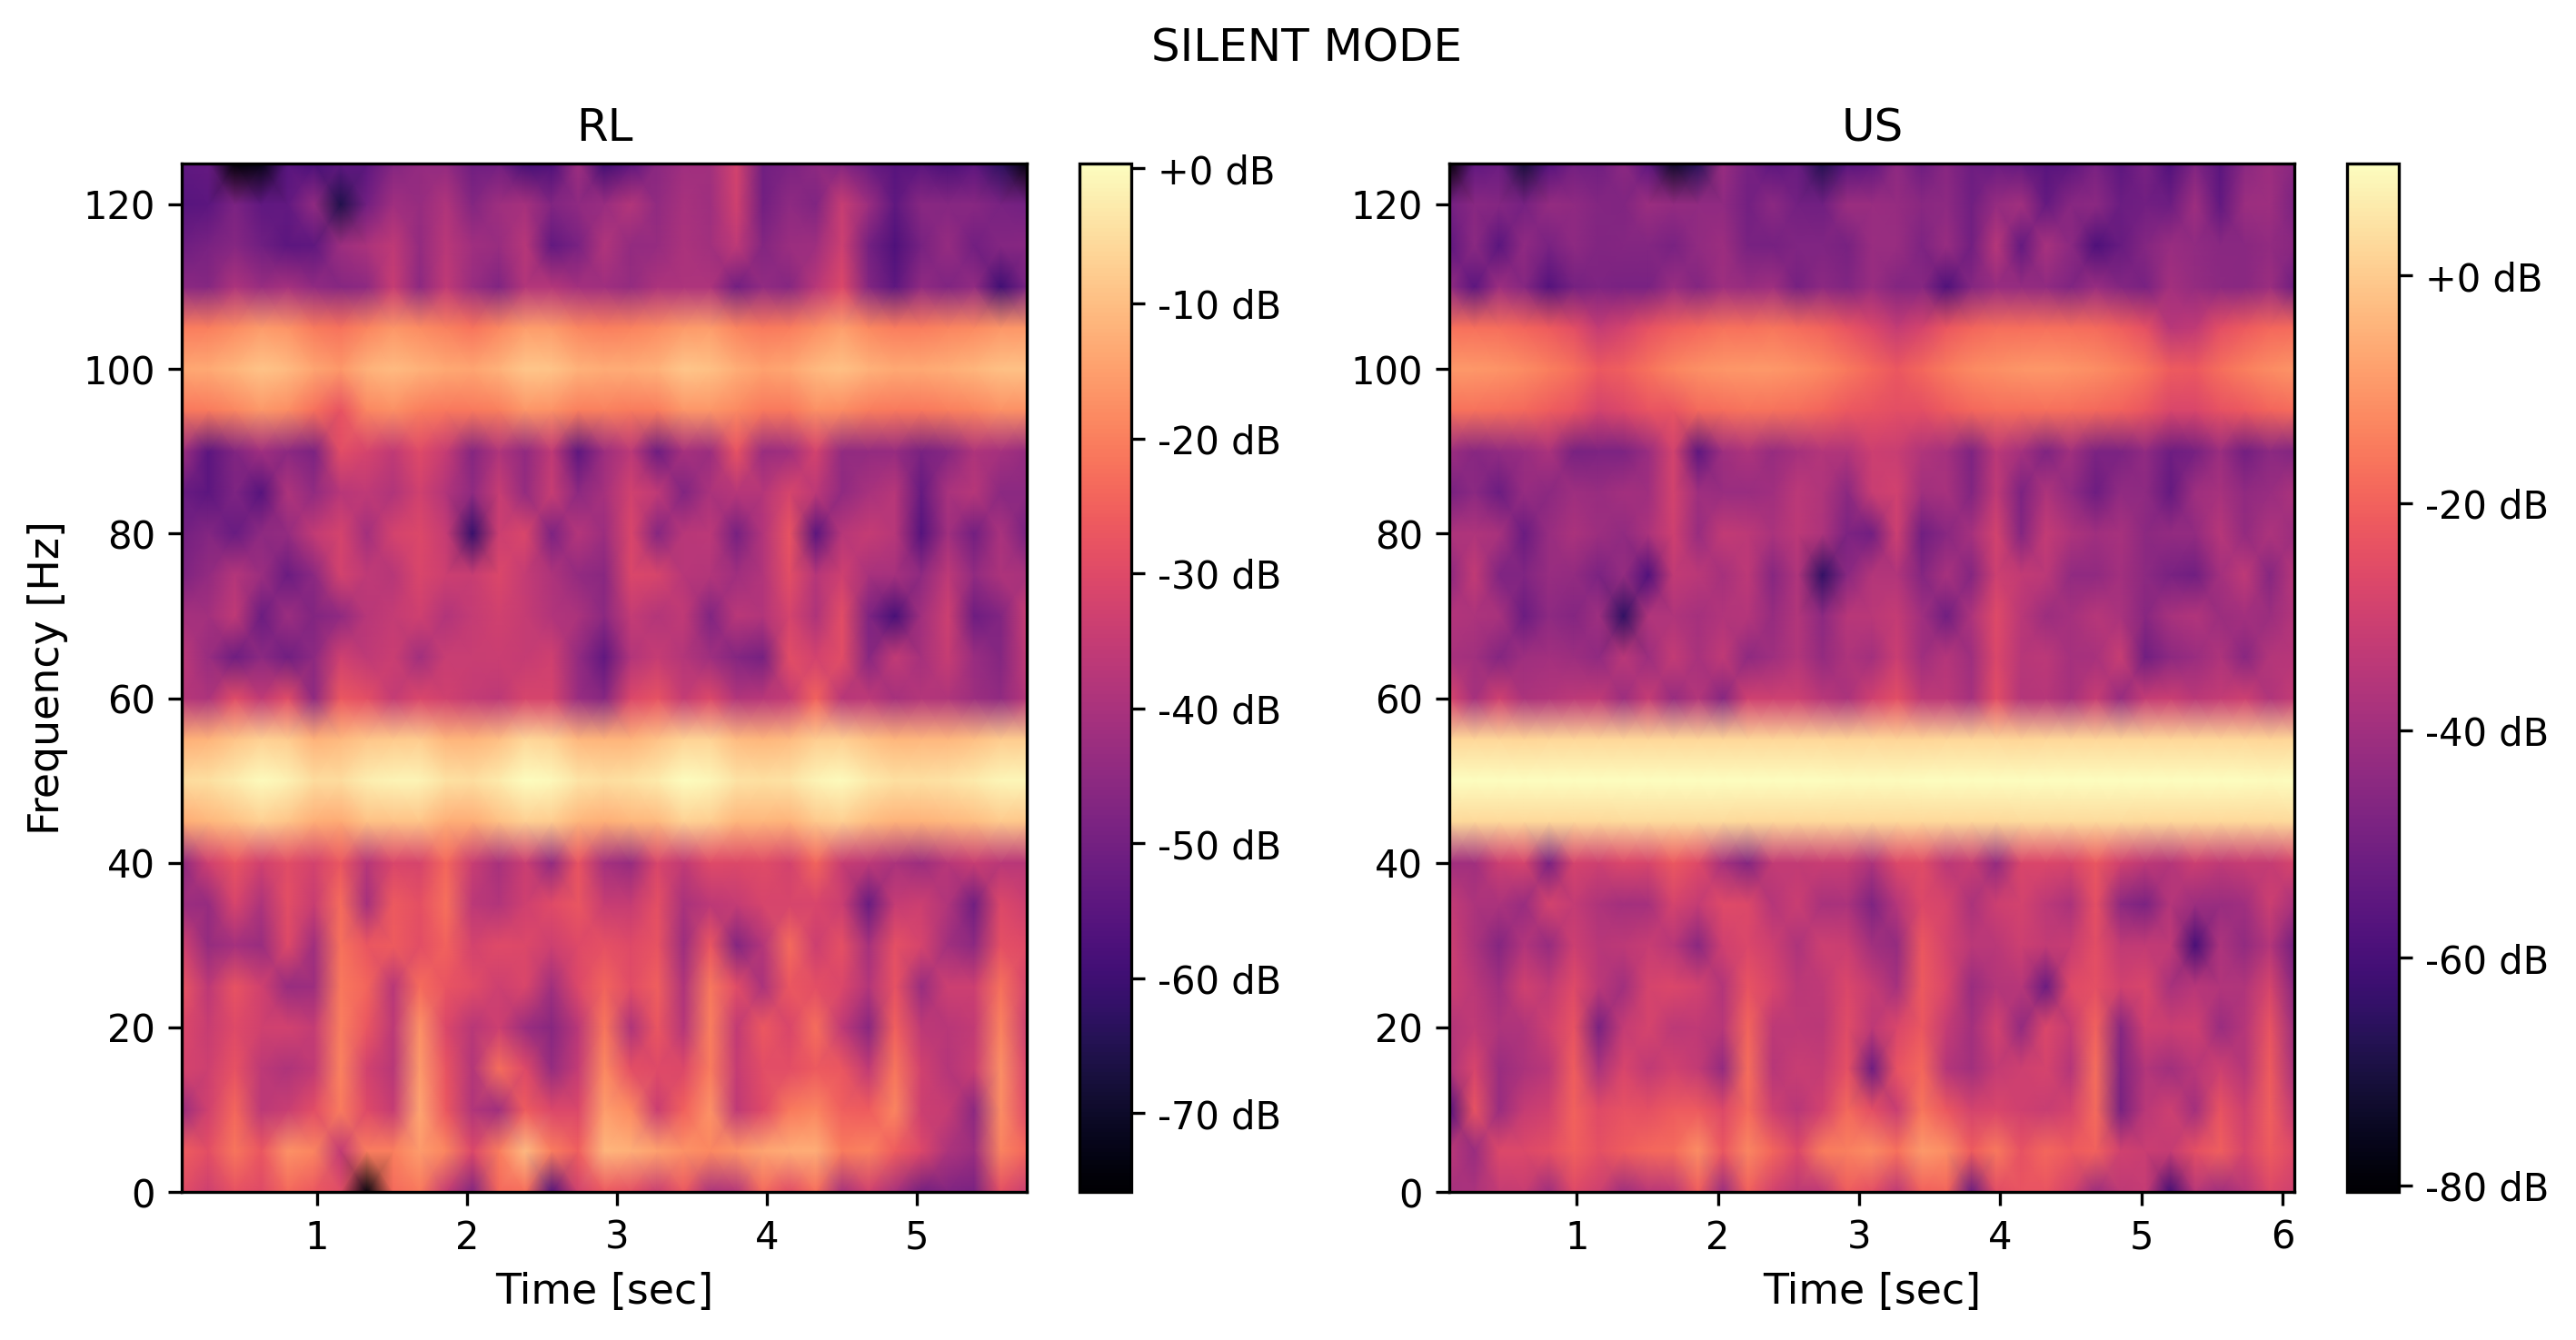

In [57]:
def SPECTOGRAM(data1,data2,MODE,channel=4):
    plt.suptitle(MODE)
    plt.subplot(121).set_title("RL")
    win = signal.windows.hamming(50)

    f, t, Sxx = signal.spectrogram(data1[:,channel], fs=SAMPLING_RATE, window = win, nperseg=len(win))
#     print(Sxx)
    plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud',cmap="magma")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
#     plt.ylim([0,20])
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(122).set_title("US")    
    f, t, Sxx = signal.spectrogram(data2[:,channel], fs=SAMPLING_RATE, window = win, nperseg=len(win))
    plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud',cmap="magma")
    plt.xlabel('Time [sec]')
#     plt.ylim([0,20])
    plt.colorbar(format='%+2.0f dB')
    plt.show()

index = 2
label = 4
SPECTOGRAM(data1=sample_sentence(index, "RL", SENTENCES[label]),data2=sample_sentence(index, "US", SENTENCES[label]),MODE="SILENT MODE")

In [64]:
def signal_pipeline(data, RICKER=False):

    """
    PIPELINE: CORRECT DC DRIFT --> CORRECT DC BIAS --> SMOOTHING SIGNAL --> NORMALIZE DATA --> FILTER DATA 
    """
    filter_data = []

    def digital_filter(data, HPF=0.5, LPF=10, H_ORDER=4, L_ORDER=4, SR=250):
        """
        FILTER PIPELINE: HPF --> NOTCH --> LPF --> RICKER CONVOLUTION
        """

        # HIGHPASS FILTER
        f_signal = biosppy.signals.tools.filter_signal(data,ftype="butter",band="highpass",order=H_ORDER,sampling_rate=SR,frequency=HPF)
        
        # NOTCH FILTER
        b,a = signal.iirnotch(50,30,SR)
        f_signal = signal.lfilter(b,a,f_signal[0])

        # LOWPASS FILTER
        f_signal = biosppy.signals.tools.filter_signal(f_signal,ftype="butter",band="lowpass",order=L_ORDER,sampling_rate=SR,frequency=LPF)

        if(RICKER==True):
            # RICKER CONVOLUTION TO REMOVE HEARTBEAT ARTIFACTS
            ricker_width = 35 * SR // 250
            ricker_sigma = 4.0 * SR / 250
            ricker = signal.ricker(ricker_width,ricker_sigma)
            # normalize ricker
            ricker = np.array(ricker, np.float32) / np.sum(np.abs(ricker))
            convolution = signal.convolve(f_signal[0],ricker,mode="same")
            return (f_signal[0]-2*convolution)

        return f_signal[0]

    def process_signal(data):
        f_data = []
        for i in range(8):
            # correction of DC drift
            c_data = data[:,i]- data[0,i]

            # correct DC bias
            c_data = c_data - np.mean(c_data)

            # normalize and filter data
            c_data = digital_filter(c_data)
            f_data.append(c_data)

        return np.array(f_data).T

    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc = "PROCESSING DATA: ")):
        temp_data = process_signal(d)
        filter_data.extend([temp_data])

    return np.array(filter_data)

In [65]:
if "data_dict_filtered.pickle" in os.listdir(PICKLE_DIR):
    print("Fetching filtered data from pickle file ...")
    all_data_filtered = pickle.load(open(os.path.join(PICKLE_DIR,"data_dict_filtered.pickle"),"rb"))
    print("Done!")
else:
    all_data_filtered = all_data.copy()
    all_data_filtered["data"] = signal_pipeline(all_data["data"])
    pickle.dump(all_data_filtered,open(os.path.join(PICKLE_DIR,"data_dict_filtered.pickle"),"wb"))
    print("Write Task Accomplished")

PROCESSING DATA: 100%|█████████▉| 2309/2310 [00:34<00:00, 66.43it/s]


Write Task Accomplished


In [66]:
print(type(all_data_filtered))
print(all_data_filtered.keys())
print([len(x[-1]) for x in all_data_filtered.items()])

<class 'dict'>
dict_keys(['data', 'speaker', 'labels', 'session', 'filename'])
[2310, 2310, 2310, 2310, 2310]


In [77]:
print(np.array(all_data_filtered["data"]).shape)

(2310,)
